In [1]:
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.cuda.amp import autocast, GradScaler
from projects.backend.GardenRobot.pipeline.garden_cnn import GardenCNN

In [2]:
cpu_transforms = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = ImageFolder(root='C:/Users/spec/Documents/programming/projects/backend/GardenRobot/pipeline/data/train', transform=cpu_transforms)
val_dataset = ImageFolder(root='C:/Users/spec/Documents/programming/projects/backend/GardenRobot/pipeline/data/val', transform=cpu_transforms)
test_dataset = ImageFolder(root='C:/Users/spec/Documents/programming/projects/backend/GardenRobot/pipeline/data/test', transform=cpu_transforms)

train_loader = DataLoader(
    train_dataset,
    batch_size=192,
    shuffle=True,
    num_workers=2,
    prefetch_factor=2,
    persistent_workers=True,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=192,
    shuffle=False,
    num_workers=2,
    prefetch_factor=2,
    persistent_workers=True,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=192,
    shuffle=False,
    num_workers=2,
    prefetch_factor=2,
    persistent_workers=True,
    pin_memory=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------------------- #

===================== RUN: 1/1 =====================
Epoch 1/20, Training Loss: 3.2158
 ------------- Best model saved | Epoch: 1, Val loss: 0.7497 ------------- 
Validation Loss: 0.7497, Accuracy: 78.26%
Epoch 2/20, Training Loss: 0.8606
 ------------- Best model saved | Epoch: 2, Val loss: 0.4841 ------------- 
Validation Loss: 0.4841, Accuracy: 85.77%
Epoch 3/20, Training Loss: 0.6757
 ------------- Best model saved | Epoch: 3, Val loss: 0.3412 ------------- 
Validation Loss: 0.3412, Accuracy: 89.25%
Epoch 4/20, Training Loss: 0.5764
 ------------- Best model saved | Epoch: 4, Val loss: 0.2958 ------------- 
Validation Loss: 0.2958, Accuracy: 90.81%
Epoch 5/20, Training Loss: 0.4919
 ------------- Best model saved | Epoch: 5, Val loss: 0.2845 ------------- 
Validation Loss: 0.2845, Accuracy: 91.67%
Epoch 6/20, Training Loss: 0.4390
 ------------- Best model saved | Epoch: 6, Val loss: 0.2789 ------------- 
Validation Loss: 0.2789, Accuracy: 90.96%
Epoch 7/20, Training Loss: 0.3970
 

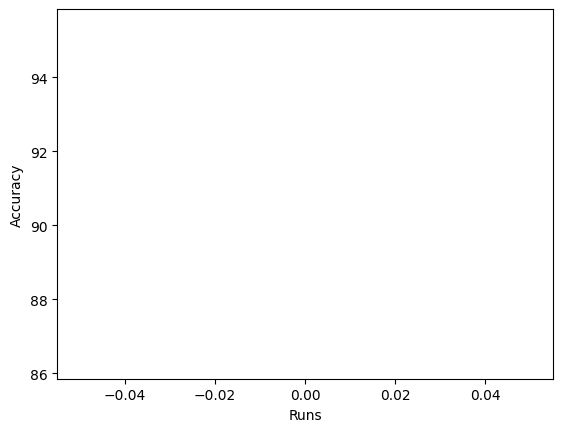

Done!


Best accuracy: 90.85%

90.84507042253522


In [3]:
# ------------------------------- #
best_accuracy: float = 0.0
results: list = []
runs: int = 1

scaler = torch.amp.GradScaler('cuda')

for i in range(runs):
    print(f"===================== RUN: {i+1}/{runs} =====================")
    model = GardenCNN().to(device)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

    scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    # ------------TRAIN--------------- #
    num_epochs: int = 20
    best_val_loss: float = math.inf

    for epoch in range(num_epochs):
        model.train()
        #running_loss: float = 0.0
        running_loss_gpu = torch.tensor(0.0, device=device)
        for images, labels in train_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.long().to(device, non_blocking=True)

            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            #loss.backward()
            #optimizer.step()

            #running_loss += loss.item()
            running_loss_gpu += loss.detach()
        avg_train_loss = running_loss_gpu.item() / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}") # running_loss / len(train_loader)

        # ------------VALIDATE--------------- #
        model.eval()
        val_correct: int = 0
        val_total: int = 0
        val_loss: float = 0.0
        with torch.inference_mode():
            for images, labels in val_loader:
                images = images.to(device, non_blocking=True)
                labels = labels.long().to(device, non_blocking=True)

                with torch.amp.autocast('cuda'):
                    outputs = model(images)
                    val_loss += criterion(outputs, labels).item()

                #outputs = model(images)
                #val_loss += criterion(outputs, labels).item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss: float = val_loss / len(val_loader)
        val_accuracy: float = 100 * val_correct / val_total

        current_best_model_path = f'garden_cnn_run_{i+1}_best.pth'

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), current_best_model_path)
            print(f" ------------- Best model saved | Epoch: {epoch + 1}, Val loss: {avg_val_loss:.4f} ------------- ")

        print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

        scheduler.step(avg_val_loss)

    # ------------TEST--------------- #

    loaded_model = GardenCNN().to(device)

    loaded_model.load_state_dict(torch.load(current_best_model_path))

    loaded_model.to(device)
    loaded_model.eval()


    test_correct: int = 0
    test_total: int = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            with torch.amp.autocast('cuda'):
                outputs = loaded_model(images)

            #outputs = loaded_model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    accuracy: float = 100 * test_correct / test_total
    results.append(accuracy)
    print('\n# ------------------------------- #\n')
    print(f"Test Accuracy: {accuracy:.2f}%\n")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        print(f"\nNew best: {best_accuracy:.2f}%\n\n")
        torch.save(loaded_model.state_dict(), "best_garden_cnn.pth")

    torch.cuda.empty_cache()
    if os.path.exists(current_best_model_path):
        os.remove(current_best_model_path)

plt.plot(results)
plt.xlabel('Runs')
plt.ylabel('Accuracy')
plt.show()
print('Done!')
print(f'\n\nBest accuracy: {best_accuracy:.2f}%\n')
print(sum(results)/len(results))
# ------------------------------- #